* Name: `dissipation-theory--Study-24.ipynb`
* Author: John A. Marohn
* Date: 2024-08-06
* Continued from: `dissipation-theory--Study-23.ipynb`
* Continued to: ---
* Summary: Plot cantilever friction versus conductivity, similar to Lekkala 203 Figures 7(b) and 9(b), but for (1) perpendicular friction and (2) plotted versus conductivity and not charge density.

# Preliminaries

In [1]:
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

font = {'family' : 'sans serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams['figure.figsize'] = 3.25, 3.5

In [3]:
from dissipationtheory.constants import ureg, qe
from dissipationtheory.dissipation2 import CantileverModelJit, SampleModel1Jit, SampleModel2Jit, theta1norm_jit
from dissipationtheory.dissipation  import blds_perpendicular_jit, gamma_perpendicular_jit
from dissipationtheory.data import BLDSData

In [4]:
THIS = 'dissipation-theory--Study-24--'
fig = {}

# Cantilever and sample

In [5]:
cantilever_jit = CantileverModelJit(
    f_c = 75e3, 
    V_ts = 1.0,
    R = 35e-9,
    d = 38e-9
)

The sample is backed by a metal, which we mimic by setting $\epsilon_{\mathrm{d}} = 10^{6}$.

In [6]:
sample_jit = SampleModel1Jit(
    cantilever = cantilever_jit,
    h_s = 500e-9,
    epsilon_s = complex(20, -0.2),
    sigma = 1e-5,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

# Step the mobility and cantilever friction

Vary the conductivity, but keep the mobility fixed, which means we must also vary charge density.

In [7]:
sigma = ureg.Quantity(
    np.logspace(
        start=np.log10(1e-9),
        stop=np.log10(1e2),
        num=60), 'S/m')

Loop over a number mobilities.  At the low end, theree are ionic mobilities; at the high end, electronic mobilities.

In [8]:
mu = ureg.Quantity([1e-9, 1e-8, 1e-7, 1e-6, 1e-5],'m^2/(V s)')

In [9]:
mu.to('cm^2/(V s)')

Magnitude,[1e-05 0.0001 0.001 0.01 0.1]
Units,centimeter2/(second volt)


Get ready to run the simulations.

In [10]:
data = {}        # many simulations
data['01'] = {}  # the first simulation

Step the conductivity (and charge density) and compute a friction at each step.

In [11]:
# remember
sigma0 = sample_jit.sigma
rho0 =  sample_jit.rho

for mu_ in mu:

    gamma = ureg.Quantity(np.zeros_like(sigma), 'pN s/m')
    
    # As we vary mu, we have to recalculate charge density
    rho = (sigma / (qe * mu_)).to('1/m^3')
    
    for index, sigma_ in enumerate(sigma):

        sample_jit.rho = rho[index].to('1/m^3').magnitude
        sample_jit.sigma = sigma_.to('S/m').magnitude        
        
        gamma[index] = gamma_perpendicular_jit(theta1norm_jit, sample_jit).to('pN s/m')[0]
    
    data['01'][str(mu_)] = {
        'mobility': mu_, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sigma, 'S/m'), 
        'rho': ureg.Quantity(rho, '1/m^3')}

# reset
sample_jit.rho = rho0
sample_jit.sigma = sigma0

In [61]:
def plotgammaA(data, sample_jit):

    # gather up mobility data

    mu = ureg.Quantity(np.zeros(len(data)), 'm^2/(V s)')
    for index, key in enumerate(data.keys()):
        mu[index] = data[key]['mobility']
        
    # now make a plot
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.75))

    with plt.style.context('seaborn-v0_8'):
        
        for mu_, key in zip(mu, data.keys()):
            lbl = "{:0.1e}".format(mu_.to('cm^2/(V s)').magnitude)
            plt.loglog(
                data[key]['rho'].to('1/m^3').magnitude, 
                data[key]['gamma'].to('pN s/m').magnitude, 
                '-',
                label=lbl)
        
    plt.ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    plt.xlabel(r'charge density $\rho$ [1/m$^3$]')
    plt.ylim([6e-2,2e2])
    plt.xlim([1e19,1e26])
    lg = plt.legend(fontsize=9, frameon=False, loc='lower left', bbox_to_anchor = (1.05, 0.3))
    lg.set_title(r'$\mu$ [cm$^2$/(V s)]', prop={'size':'small'})

    
    plt.tight_layout()
    plt.show()
    
    return fig

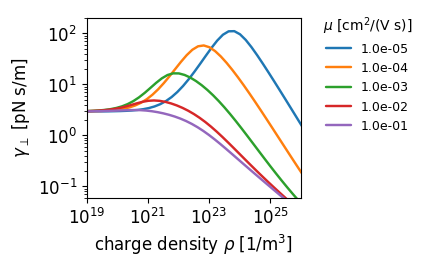

In [62]:
fig['01'] = plotgammaA(data['01'], sample_jit)

Print out the simulation parameters:

* Cantilever: $f_c = 75 \: \mathrm{kHz}$, $k_c = 2.8 \: \mathrm{N/m}$, $R = 35 \: \mathrm{nm}$, $h = 38 \: \mathrm{nm}$, and $V_{\mathrm{ts}} = 1 \: \mathrm{V}$.

* Sample: $h_{\mathrm{s}} = 500 \: \mathrm{nm}$, $\epsilon_{\mathrm{s}} = 20 - 0.2 \, j$, $\epsilon_{\mathrm{d}} = 10^{6}$ fixed; $\sigma$ varied, $\mu$ varied, and $\rho = \sigma/(e \mu)$.

# Show that dielectric fluctuations can obscure friction.

Pick one mobility, vary the imaginary part of the dielectric constant.

In [46]:
sample_jit = SampleModel1Jit(
    cantilever = cantilever_jit,
    h_s = 500e-9,
    epsilon_s = complex(20, -0.2),
    sigma = 1e-7,
    rho = 1e21,
    epsilon_d = complex(1e6, 0),
    z_r = 300e-9
)

Various dielectric constants, varying the imaginary part.

In [47]:
epsilon = [complex(20, a) for a in [-0.002, -0.02, -0.2, -2]]
epsilon 

[(20-0.002j), (20-0.02j), (20-0.2j), (20-2j)]

Now loop over dielectric constant.

In [48]:
data['02'] = {}  # the first simulation

# remember
epsilon_init = sample_jit.epsilon_s

# make sure we havee the right charge density
# by recomputing it from the conductivity and the mobility

rho = (sigma / (qe * ureg.Quantity(1e-4, 'cm^2/(V s)'))).to('1/m^3')

for eps in epsilon:

    gamma = ureg.Quantity(np.zeros_like(sigma), 'pN s/m')
    
    for index, sigma_ in enumerate(sigma):

        sample_jit.epsilon_s = eps
        sample_jit.rho = rho[index].to('1/m^3').magnitude
        sample_jit.sigma = sigma_.to('S/m').magnitude 
        
        
        gamma[index] = gamma_perpendicular_jit(theta1norm_jit, sample_jit).to('pN s/m')[0]
    
    data['02'][str(eps.imag)] = {
        'epsilon': eps, 
        'gamma': gamma,
        'sigma': ureg.Quantity(sigma, 'S/m'), 
        'rho': ureg.Quantity(rho, '1/m^3')}

# reset
sample_jit.epsilon_s = epsilon_init

In [63]:
def plotgammaB(data, sample_jit):

    # gather up dielectric constant data

    epsilson = np.zeros(len(data))
    for index, key in enumerate(data.keys()):
        epsilon[index] = data[key]['epsilon'].imag
        
    # now make a plot
    
    fig, ax = plt.subplots(1, 1, figsize=(4.5, 2.75))

    with plt.style.context('seaborn-v0_8'):
        
        for eps, key in zip(epsilon, data.keys()):
            lbl = "{:0.3f}".format(-1 * eps)
            plt.loglog(
                data[key]['rho'].to('1/m^3').magnitude, 
                data[key]['gamma'].to('pN s/m').magnitude, 
                '-',
                label=lbl)
        
    plt.ylabel(r'$\gamma_{\perp}$ [pN s/m]')
    plt.xlabel(r'charge density $\rho$ [1/m$^3$]')
    plt.ylim([6e-2,2e2])
    plt.xlim([1e19,1e26])
    lg = plt.legend(fontsize=9, frameon=False, loc='lower left', bbox_to_anchor = (1.05, 0.4))
    lg.set_title(r'$- \epsilon^{\prime\prime}$', prop={'size':'small'})

    plt.tight_layout()
    plt.show()
    
    return fig

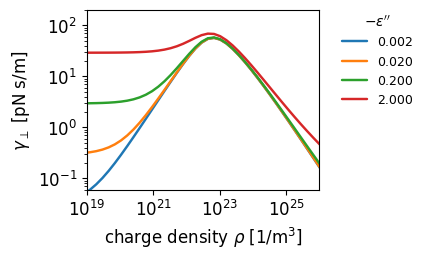

In [64]:
fig['02'] = plotgammaB(data['02'], sample_jit)

Print out the simulation parameters:

* Cantilever (same as above): $f_c = 75 \: \mathrm{kHz}$, $k_c = 2.8 \: \mathrm{N/m}$, $R = 35 \: \mathrm{nm}$, $h = 38 \: \mathrm{nm}$, and $V_{\mathrm{ts}} = 1 \: \mathrm{V}$.

* Sample: $h_{\mathrm{s}} = 500 \: \mathrm{nm}$, $\epsilon_{\mathrm{s}} = 20$ with the imaginary part varied, $\epsilon_{\mathrm{d}} = 10^{6}$ fixed; $\mu = 10^{-4} \: \mathrm{cm}^2/(\mathrm{V s})$, $\sigma$ varied, and $\rho = \sigma/(e \mu)$.

# Save all figures

In [65]:
for num in fig.keys():
    figname = THIS + "Fig-" + num
    fig[num].savefig(figname + '.png', dpi=300)
    fig[num].savefig(figname + '.pdf')